# computational check for LR model
Tim Tyree<br>
6.22.2022

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from numba import njit
#load the libraries
from lib import *

#automate the boring stuff
# from IPython import utils
import time, os, sys, re
beep = lambda x: os.system("echo -n '\\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
    nb_dir = os.getcwd()
    
%autocall 1
%load_ext autoreload
%autoreload 2

Automatic calling is: Smart


/Users/timothytyree/opt/miniconda3/envs/pyenv/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [3]:
from lib.my_initialization import *
%autocall 1
%load_ext autoreload
%autoreload 2
# awareness&chill

Automatic calling is: Smart
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
#reset matplotlib
import matplotlib as mpl
# import seaborn as sns
# sns.reset_orig()
mpl.rc_file_defaults()
import matplotlib.ticker as mtick

Q: am I using the same initial conditions as WJ?

`c init. conditions
      open(unit=40,file='init_cond_rest',status='unknown')
      read(40,*)u,ca,x1,xm,xh,xj,xd,xf`


`
cat init_cond_rest  
  -84.660321188012958        1.4545256072491180E-007   5.5810241673725797E-003   1.6354133541151676E-003  0.98371668922815847       0.98977009269126759        2.9491168042779553E-003  0.99998163447373467  
`

`      write(10,*)u,ca,x1,xm,xh,xj,xd,xf`

# define module

In [5]:
# @njit
# def I_stim(I_magnitude=10,t_duration=5.):
#     return I_magnitude

def get_mycomp_ionic_flux(GNa=16.,#matches wj
                          GK1=0.6047, #not used
                          Gsi=0.052,#matches wj
                          EK1=-87.94,#not used
                          Eb=-59.87,#not used
                          ENa=54.4,#matches wj
                          **kwargs):#,GK=0.423
    # #maximum conductances
    # GNa = 16.     #mS/cm^2 from Qu2000.pdf #GNa=23 in Luo1990.pdf
    # GK1 = 0.6047  #mS/cm^2 from Qu2000.pdf
    # Gsi = 0.052   #mS/cm^2 spiral wave breakup phase from Qu2000.pdf
    # GK  = 0.423   #mS/cm^2 #from Qu2000.pdf
    # #reversal potentials
    # EK1 = -87.94 #mV
    # EKp = EK1    #mV
    # Eb  = -59.87 #mV
    # ENa = 54.4   #mV

    @njit
    def comp_ionic_flux(V,inCgate,IK1T,x1,Ca_i):
        """returns updated  gating variables"""
        m = inCgate[0] #activation gate parameter (Na)
        h = inCgate[1] #fast inactivation gate parameter (INa)
        j = inCgate[2] #slow inactivation gate parameter (INa)
        d = inCgate[3] #activation gate parameter (Isi)
        f = inCgate[4] #inactivation gate parameter (Isi)
        x_var = inCgate[5] #activation gate parameter (IK)
        #Fast sodium current
        INa = GNa*m**3*h*j*(V-ENa)
        #Slow inward current
        # Esi=7.7-13.0287*np.log(Ca_i)#mV  #from Luo1990.pdf
        Esi=-82.3-13.0287*np.log(Ca_i)#mV  #from lr_d0.f (WJ)
        Isi=Gsi*d*f*(V-Esi)
        #time dependent potassium current 
        IK=x_var*x1#GK*x_var*x1#
        ##total electric current
        #Iion=INa+IK1T+Isi+IK
        #calcium uptake rate (dominated by activity of the sarcoplasmic reticulum)
        # dCa_i_dt=-10**-4*Isi+0.07*(10**-4-Ca_i) #mM #from Luo1990.pdf
        dCa_i_dt=-10**-7 * Isi + 0.07*(10**-7 - Ca_i)   #M  #from lr_d0.f (WJ)
        return INa,IK1T,Isi,IK, dCa_i_dt
    return comp_ionic_flux

__goto__ - 'Luo-Rudy Model.ipynb' and see chapter `Action potentials from the LR model in 0D` for a computational check _versus_ the result of ./lib/model/comp_check_LR/run_test_LR.sh _with respect to_ voltage as a function of time.

# Generate reference data from fortranic implementation

In [6]:
os.chdir(f'{nb_dir}/lib/model/comp_check_LR')
!./run_test_LR.sh

ld: library not found for -lSystem
collect2: error: ld returned 1 exit status
dyld[2723]: Library not loaded: /usr/local/opt/gcc/lib/gcc/10/libgfortran.5.dylib
  Referenced from: <98D3F77C-F7BD-3EC2-924E-16867AF16D1C> /Users/timothytyree/Documents/GitHub/care/notebooks/lib/model/comp_check_LR/lr_0d.x
  Reason: tried: '/usr/local/opt/gcc/lib/gcc/10/libgfortran.5.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/gcc/lib/gcc/10/libgfortran.5.dylib' (no such file), '/usr/local/opt/gcc/lib/gcc/10/libgfortran.5.dylib' (no such file), '/usr/local/lib/libgfortran.5.dylib' (no such file), '/usr/lib/libgfortran.5.dylib' (no such file, not in dyld cache)
./run_test_LR.sh: line 10:  2723 Abort trap: 6           ./lr_0d.x
qt.qpa.fonts: Populating font family aliases took 282 ms. Replace uses of missing font family "Sans" with one that exists to avoid this cost. 


# Generate my data (Simulation of 1-3 externally stimulated 0D action potentials from the Luo-Rudy model using the lookup table generated by `gener_table.py` in lib.model)

In [7]:
# # this is the original version that resulted from my first computational check task with LR against WJ's fortranic onestep method.
# # #initialize system using resting state from WJ
# dt=0.1 #ms
# V   = -84.660321188012958
# Ca_i= 1.4545256072491180E-007

# x_var   =  5.5810241673725797E-003
# m   =  1.6354133541151676E-003
# h   =  0.98371668922815847
# j   =  0.98977009269126759
# d   =  2.9491168042779553E-003
# f   =  0.99998163447373467

# inCgate=np.array([m,h,j,d,f,x_var])
# outCgate=inCgate.copy()
# #initialize methods
# Cm=1. # µF/cm^2 membrane capacitance determined by gap junctions between myocardial cells
# #precompute lookup table
# arr39=get_arr39(dt,nb_dir)
# v_values=arr39[:,0]
# lookup_params=get_lookup_params(v_values,dv=0.1)
# mycomp_ionic_flux=get_mycomp_ionic_flux()
# #[V,Ca_i,m,h,j,d,f,x_var]

# tf = 500#ONE_SPIKE
# # tf =2000#up to 2 seconds
# count=0.
# dur=5.
# mag=-10.#
# #       xstim=10.
# #       tstim=5.
# #       nstim=nint(tstim/dt)
# # forward integrate to tf
# num_time_steps=int(tf/dt)
# t_values=np.array([j*dt for j in range(num_time_steps)])

# #forward euler integrate V to time t, saving all dynamic values
# V_lst = [];m_lst=[];h_lst=[];j_lst=[];d_lst=[];f_lst=[];x_var_lst=[];Ca_i_lst=[]
# IK_lst=[];INa_lst=[];ICa_lst=[];Istim_lst=[];Iion_lst=[]
# t=0
# # for step in range(num_time_steps):
# #     t+=dt
# t_values=np.arange(dt,500+dt,dt)
# # t_values+=dt #to match wj's implementation
# for t in t_values:
#     #compute currents
#     arr_interp=lookup_params(V,arr39)
#     x_infty,tau_x,m_infty,tau_m,h_infty,tau_h,j_infty,tau_j,d_infty,tau_d,f_infty,tau_f,IK1T,x1,e1,em,eh,ej,ed,ef=arr_interp[1:]
#     INa,IK1T,Isi,IK,dCa_i_dt=mycomp_ionic_flux(V,inCgate,IK1T,x1,Ca_i)
#     Iion=INa+IK1T+Isi+IK
#     #compute external stimulus
#     if ((t>0.) & (t<=0.+dur))|((t>500.) & (t<=500.+dur))|((t>1000.) & (t<=1000.+dur)):
#     #     if ((t>0.) & (t<0.+dur)):#ONE_SPIKE
#         Istim=mag
#     else:
#         Istim=0.
    
#     #record time and variables
#     m,h,j,d,f,x_var=inCgate.T
#     V_lst.append(V);m_lst.append(m);h_lst.append(h);j_lst.append(j);d_lst.append(d);f_lst.append(f);x_var_lst.append(x_var);Ca_i_lst.append(Ca_i)
#     Istim_lst.append(Istim);IK_lst.append(IK+IK1T);ICa_lst.append(Isi);INa_lst.append(INa);Iion_lst.append(Iion)
    
#     #integrate variables
#     comp_exact_next_gating_var(inCgate, outCgate, arr_interp)
#     inCgate=outCgate.copy()
#     dVdt=-(Iion+Istim)/Cm
#     V += dt*dVdt
#     Ca_i+=dt*dCa_i_dt
#     #update time
#     #     t+=dt
#     count+=1
# #     printProgressBar(count,num_time_steps)
# V_values=np.array(V_lst)
# #gating values
# m_values=np.array(m_lst)
# h_values=np.array(h_lst)
# j_values=np.array(j_lst)
# d_values=np.array(d_lst)
# f_values=np.array(f_lst)
# x_var_values=np.array(x_var_lst)
# Ca_i_values=np.array(Ca_i_lst)
# #current values
# IK_values=np.array(IK_lst)
# ICa_values=np.array(ICa_lst)
# INa_values=np.array(INa_lst)
# Istim_values=np.array(Istim_lst)
# Iion_values=np.array(Iion_lst)
# beep(1)

In [8]:
get_arr39

<function lib.model.LR_model_optimized.get_arr39(dt, nb_dir)>

In [9]:
# #initialize system using resting state from WJ
V   = -84.660321188012958
Ca_i= 1.4545256072491180E-007
x_var   =  5.5810241673725797E-003
m   =  1.6354133541151676E-003
h   =  0.98371668922815847
j   =  0.98977009269126759
d   =  2.9491168042779553E-003
f   =  0.99998163447373467

tf = 500 #ms
dt=0.1   #ms
count=0.
dur=5.
mag=-10
Cm=1. # µF/cm^2 membrane capacitance determined by gap junctions between myocardial cells
saving=True


inCgate=np.array([m,h,j,d,f,x_var])
outCgate=inCgate.copy()
#initialize methods
#precompute lookup table
arr39=get_arr39(dt,nb_dir)
v_values=arr39[:,0]
lookup_params=get_lookup_params(v_values,dv=0.1)
mycomp_ionic_flux=get_mycomp_ionic_flux()
#[V,Ca_i,m,h,j,d,f,x_var]


# forward integrate to tf
num_time_steps=int(tf/dt)

#forward euler integrate V to time t, saving all dynamic values
V_lst = [];m_lst=[];h_lst=[];j_lst=[];d_lst=[];f_lst=[];x_var_lst=[];Ca_i_lst=[]
IK_lst=[];INa_lst=[];ICa_lst=[];Istim_lst=[];Iion_lst=[]
# for step in range(num_time_steps):
#     t+=dt
# t_values=np.array([j*dt for j in range(num_time_steps)])
# t_values+=dt #to match wj's implementation
t_values=np.arange(dt,500+dt,dt) #to match wj's implementation
for t in t_values:
    #compute currents
    arr_interp=lookup_params(V,arr39) #waarden
    x_infty,tau_x,m_infty,tau_m,h_infty,tau_h,j_infty,tau_j,d_infty,tau_d,f_infty,tau_f,IK1T,x1,e1,em,eh,ej,ed,ef=arr_interp[1:]
    INa,IK1T,Isi,IK,dCa_i_dt=mycomp_ionic_flux(V,inCgate,IK1T,x1,Ca_i)
    Iion=INa+IK1T+Isi+IK
    #compute external stimulus
    if ((t>0.) & (t<=0.+dur))|((t>500.) & (t<=500.+dur))|((t>1000.) & (t<=1000.+dur)):
    #     if ((t>0.) & (t<0.+dur)):#ONE_SPIKE
        Istim=mag
    else:
        Istim=0.
    
    #record time and variables
    m,h,j,d,f,x_var=inCgate.T
    V_lst.append(V);m_lst.append(m);h_lst.append(h);j_lst.append(j);d_lst.append(d);f_lst.append(f);x_var_lst.append(x_var);Ca_i_lst.append(Ca_i)
    Istim_lst.append(Istim);IK_lst.append(IK+IK1T);ICa_lst.append(Isi);INa_lst.append(INa);Iion_lst.append(Iion)
    
    #integrate variables
    comp_exact_next_gating_var(inCgate, outCgate, arr_interp)
    inCgate=outCgate.copy()
    dVdt=-(Iion+Istim)/Cm
    V += dt*dVdt
    Ca_i+=dt*dCa_i_dt
    #update time
    #     t+=dt
    count+=1
#     printProgressBar(count,num_time_steps)
V_values=np.array(V_lst)
#gating values
m_values=np.array(m_lst)
h_values=np.array(h_lst)
j_values=np.array(j_lst)
d_values=np.array(d_lst)
f_values=np.array(f_lst)
x_var_values=np.array(x_var_lst)
Ca_i_values=np.array(Ca_i_lst)
#current values
IK_values=np.array(IK_lst)
ICa_values=np.array(ICa_lst)
INa_values=np.array(INa_lst)
Istim_values=np.array(Istim_lst)
Iion_values=np.array(Iion_lst)
beep(1)

-n 


0

In [10]:
df=pd.DataFrame({
    't':t_values,
    'V':V_values,
    'Ca_i':Ca_i_values,
    'INa':INa_values,
    'IK' :IK_values,
    'ICa':ICa_values,
    'Istim':Istim_values,
    'm':m_values,
    'h':h_values,
    'j':j_values,
    'd':d_values,
    'f':f_values,
    'x_var':x_var_values,
})

if saving:
    os.chdir(os.path.join(nb_dir,'Figures/methods'))
    df.to_csv(f'LR_action_potentials_optimized_tf_{tf}.csv')
    os.path.abspath(f'LR_action_potentials_optimized_tf_{tf}.csv')

# DONE: quantify the disagreement between the two one step methods

In [11]:
#load results from earlier
os.chdir(os.path.join(nb_dir,'Figures/methods'))
# df=pd.read_csv('LR_action_potentials_optimized.csv')
df=pd.read_csv('LR_action_potentials_optimized_tf_500.csv')

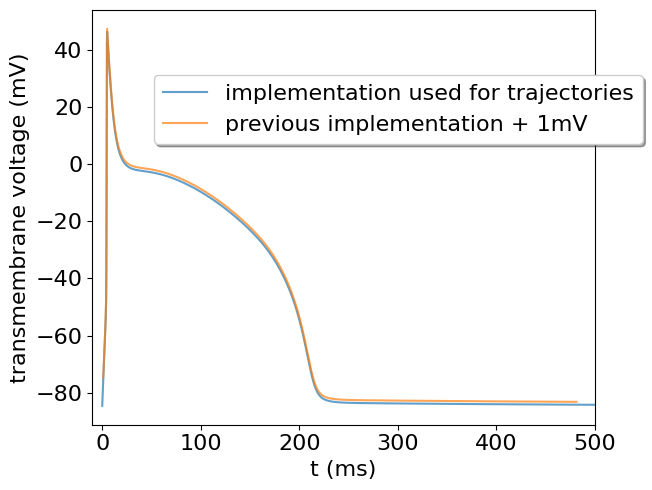

In [12]:
#load WJ's results
os.chdir(os.path.join(nb_dir,'lib/model/comp_check_LR'))
wj=np.loadtxt('fort.1')
col1,col1,col3,col4=wj.T
V=col1
t_values=df.t.values[:5000]
V_values=df.V.values[:5000]

#plot the results from either one step method
fontsize=16
save=True
plt.subplots(figsize=(6.5,5))
plt.plot(t_values,V_values,alpha=0.7,label='implementation used for trajectories')
plt.plot(t_values[10::10][:V.shape[0]],V+1,alpha=0.7,label='previous implementation + 1mV')
# plt.plot(V+1,alpha=0.7,label='previous implementation + 1mV')

# plt.y_label
# plt.plot(t_values,V_values,c='k')
plt.legend(ncol=1, fontsize=fontsize, bbox_to_anchor=(.1,.87), fancybox=True, shadow=True)
# plt.yscale('log')
plt.tick_params(labelsize=fontsize)
plt.xlabel(r't (ms)', fontsize=fontsize)
plt.tight_layout()
plt.xlim([-10,500])
plt.ylabel('transmembrane voltage (mV)', fontsize=fontsize)
# plt.xlim([-10,200])
if not save:
    plt.show()
else:
    os.chdir(os.path.join(nb_dir,'Figures/methods'))
    savefig_fn='comp_check_LR.png'
    plt.tight_layout()
    plt.savefig(savefig_fn,dpi=300)

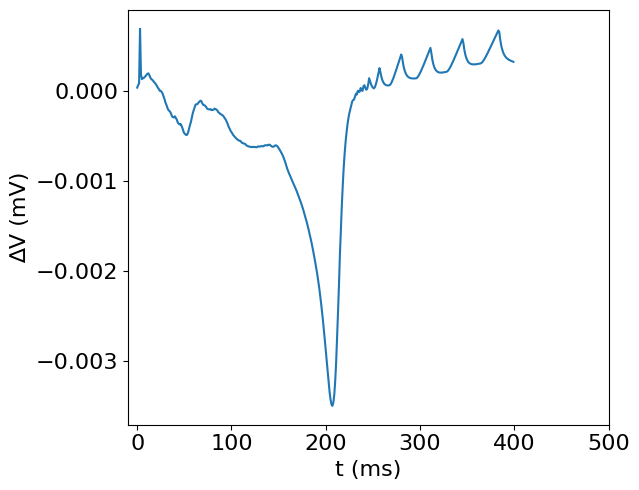

In [13]:
i=10 #max ∆V < 0.1mV
# i=9 #max ∆V < 0.1mV
a=V[:-1]
b=V_values[i::10]
diff_values=a[:400]-b[:400]
diff_values
#voltage
fontsize=16
save=True

plt.subplots(figsize=(6.5,5))
plt.plot(diff_values)
# plt.y_label
# plt.plot(t_values,V_values,c='k')
# plt.legend(ncol=1, fontsize=fontsize, bbox_to_anchor=(.1,.87), fancybox=True, shadow=True)
# plt.yscale('log')
plt.tick_params(labelsize=fontsize)
plt.xlabel(r't (ms)', fontsize=fontsize)
plt.tight_layout()
plt.xlim([-10,500])
plt.ylabel('∆V (mV)', fontsize=fontsize)
# plt.xlim([-10,200])
if not save:
    plt.show()
else:
    os.chdir(os.path.join(nb_dir,'Figures/methods'))
    savefig_fn='comp_check_LR_disagreement.png'
    plt.tight_layout()
    plt.savefig(savefig_fn,dpi=300)

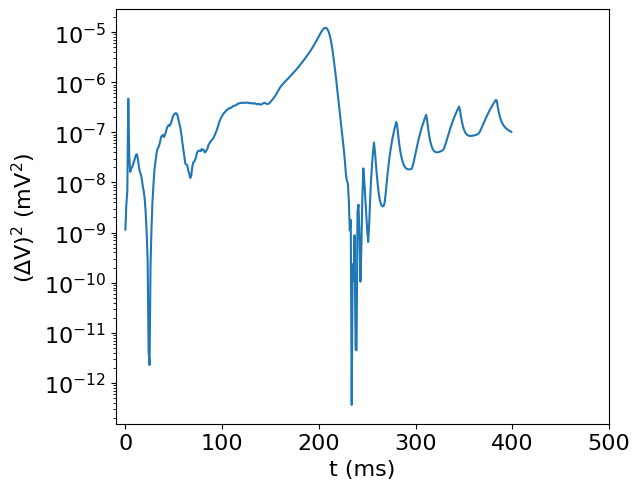

In [14]:
a=V[:-1]
b=V_values[i::10]
diff_values=a[:400]-b[:400]
diff_values
#voltage
fontsize=16
save=True

plt.subplots(figsize=(6.5,5))
plt.plot(diff_values**2)
# plt.y_label
# plt.plot(t_values,V_values,c='k')
# plt.legend(ncol=1, fontsize=fontsize, bbox_to_anchor=(.1,.87), fancybox=True, shadow=True)
# plt.yscale('log')
plt.tick_params(labelsize=fontsize)
plt.xlabel(r't (ms)', fontsize=fontsize)
plt.tight_layout()
plt.xlim([-10,500])
plt.ylabel(r'(∆V)$^2$ (mV$^2$)', fontsize=fontsize)
# plt.xlim([-10,200])
plt.yscale('log')
if not save:
    plt.show()
else:
    os.chdir(os.path.join(nb_dir,'Figures/methods'))
    savefig_fn='comp_check_LR_disagreement.png'
    plt.tight_layout()
    plt.savefig(savefig_fn,dpi=300)

In [15]:
V_values[11::10][:10]

array([-74.84246883, -66.94785799, -58.90397416, -43.77528443,
        45.98372114,  39.87740207,  34.22136256,  29.1130502 ,
        24.5348842 ,  20.47508261])

The apparent disagreement may be the result of accumulated error resulting from floating point arithmetic.  Fortran handles this differently from Python, as memory serves.  This is an excitable system, after all.

Other potential causes: 
- is slow inward current computed the same?
- is initialization the same?
- is t+=dt also at the start?
- am i using the exact solution for the gating variables?

#Slow inward current
    #Difference Spotted between Esi and vca
    #Q: does this difference explain ∆V?
    #Q(if so): does this difference exist in what I used in generating the LR trajectories?
    #Esi=7.7-13.0287*np.log(Ca_i)#mV  vca=-82.3d0-13.0287d0*dlog(ca)
    Esi=-82.3-13.0287*np.log(Ca_i)#mV  vca=-82.3d0-13.0287d0*dlog(ca)
    Isi=Gsi*d*f*(V-Esi)        #xica=gca*xd*xf*(u-vca)
    #calcium uptake rate (dominated by activity of the sarcoplasmic reticulum)
    #Difference Spotted between Esi and vca
    #Q: does this difference explain ∆V?
    #Q(if so): does this difference exist in what I used in generating the LR trajectories?
    dCa_i_dt=-10**-4*Isi+0.07*(10**-4-Ca_i)  # cao=-1.d-7*xica +.07d0*(1.d-7-ca)


# DONE: estimate action potential duration versus threshold

In [16]:
#input: t_values,V_values
#output: thresh_values,AP_values
thresh_values=np.linspace(np.min(V_values)+0.1,
                          np.max(V_values)-0.1,
                          1000)

In [17]:
dt_ = np.diff(t_values)[0]

In [18]:
AP_lst=[]
for thresh in thresh_values:
    boo=V_values>=thresh
#     AP=np.diff(boo).sum()*dt_  #<<< assumes bi-monotonic action potential
    AP=boo.sum()*dt_  #<<< assumes bi-monotonic action potential
    #record
    AP_lst.append(AP)
AP_values=np.array(AP_lst); del AP_lst

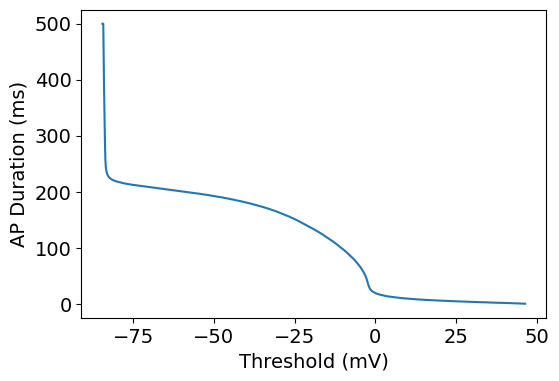

In [19]:
fig,ax=plt.subplots(figsize=(6,4))
ax.plot(thresh_values,AP_values)
format_plot(ax=ax,xlabel='Threshold (mV)',ylabel='AP Duration (ms)',fontsize=14)
plt.show()

In [20]:
#TODO: convert yaxis to cm using conduction_velocity
#TODO: highlight/mark -40mV to indicate the value put in the table
#TODO: repeat ^this plot for FK model
#TODO: put both values in Table 1
#TODO: mention new values in Table 1 in the response to Referees
#TODO: update Table 2.1 in Dissertation with ^that value
conduction_velocity=51 #cm/s #FK
conduction_velocity=33 #cm/s #LR
DX=0.025

In [21]:
# np.isclose(thresh_values,-40.,atol=).any()
hwindow=0.02 #mV
thresh=-40 #mV
boo=(thresh_values-hwindow<=thresh)&(thresh_values+hwindow>=thresh)
boo.any(),boo.shape,V_values.shape

(True, (1000,), (5000,))

In [22]:
# boo

In [23]:
ymean=np.mean(AP_values[boo])

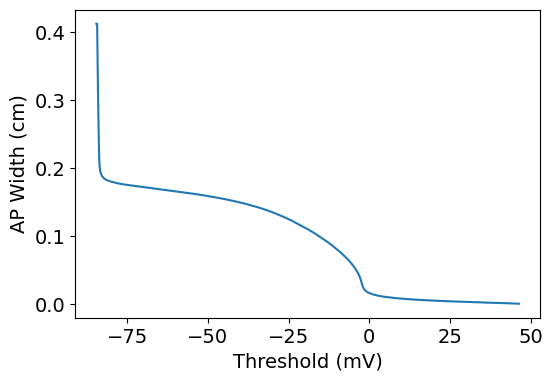

In [24]:
fig,ax=plt.subplots(figsize=(6,4))
ax.plot(thresh_values,AP_values*conduction_velocity*1e-3*DX)


format_plot(ax=ax,xlabel='Threshold (mV)',ylabel='AP Width (cm)',fontsize=14)
plt.show()

In [25]:
print(f"at {thresh=} mV, we have AP Duration: {ymean:.4f} ms")
print(f"at {thresh=} mV, we have AP Width: {ymean*conduction_velocity*1e-3*DX:.4f} cm")

at thresh=-40 mV, we have AP Duration: 180.7000 ms
at thresh=-40 mV, we have AP Width: 0.1491 cm


# repeat for FK model

In [223]:
# step function
@njit
def step(a,b):
    return 1 if a<=b else 0 # nan yields 1

def comp_ionic_transient_fk(vlt,fig,sig):
    """
    Example Usage:
dVlt2dt,dFig2dt,dSig2dt = comp_ionic_transient_fk(vlt,fig,sig)
    """
    C_m      = 1.000  # 􏰎microFarad/cm^2 
    #parameter set 8 of FK model from Fenton & Cherry (2002)
    tau_pv   = 13.03
    tau_v1   = 19.6
    tau_v2   = 1250
    tau_pw   = 800
    tau_mw   = 40
    tau_d    = 0.45# also interesting to try, but not F&C8's 0.45: 0.407#0.40#0.6#
    tau_0    = 12.5
    tau_r    = 33.25
    tau_si   = 29#
    K        = 10
    V_sic    = 0.85#
    V_c      = 0.13
    V_v      = 0.04
    C_si     = 1  # I didn't find this (trivial) multiplicative constant in Fenton & Cherry (2002).  The value C_si = 1 was used in Kaboudian (2019).
    dx, dy   = (1, 1)# (1/512, 1/512) # size of a pixel

    # /*-------------------------------------------------------------------------
    #  * Calculating right hand side vars
    #  *-------------------------------------------------------------------------
    #  */
    p = step(V_c, vlt)
    q = step(V_v, vlt)
    
    #original FK model
    #     tau_mv = (1.0 - q) * tau_v1 + q * tau_v2
    #FK model with tau_v2 and tau_v1 switched
    tau_mv = (1.0 - q) * tau_v2 + q * tau_v1
    
    Ifi = -fig * p * (vlt - V_c) * (1.0 - vlt) / tau_d
    Iso = vlt * (1.0 - p) / tau_0 + p / tau_r

    tn = Tanh(K * (vlt - V_sic))
    Isi = -sig * (1.0 + tn) / (2.0 * tau_si)
    Isi *= C_si
    dFig2dt = (1.0 - p) * (1.0 - fig) / tau_mv - p * fig / tau_pv
    dSig2dt = (1.0 - p) * (1.0 - sig) / tau_mw - p * sig / tau_pw
    
    I_sum = Isi + Ifi + Iso
    dVlt2dt = - I_sum / C_m
    return dVlt2dt,dFig2dt,dSig2dt

In [224]:
# get_time_step_fk,one_step_fk=recall_flow_map_fk(nb_dir=nb_dir,diffCoef=0.0005,width=200,height=200,dsdpixel=0.025)
get_time_step_fk,one_step_fk=recall_flow_map_fk(nb_dir=nb_dir,diffCoef=0.0005,width=1,height=1,dsdpixel=0.025)


# get_time_step_fk(txt, dtxtdt)

param_fn is param_set_8.json.


In [225]:
# txt.shape

In [226]:
# #FK
# data_dir=f"{nb_dir}/Data/initial-conditions-suite-1/ic-in/ic_200x200.121.33.npz"
# txt=load_buffer(data_dir)
# val=txt[2,90]

In [265]:
# txt=load_txt
# val=np.array([0.95323689, 0.03156947, 0.83480313])
# val=np.array([0.94086643, 0.02150845, 0.82960188])
# val=np.array([0.92042215, 0.01465382, 0.82443303])
# val=np.array([0.1, 0.0, 0.9])
# val=np.array([0.09231135, 0.04974196, 0.90246904])
# val=np.array([0.09231135, 0.9, 0.90246904])
# val=np.array([0.08521385, 0.9049742 , 0.90487712])
# val=np.array([0.0, 0.9049742 , 0.90487712])
# val=np.array([1.24313601e-09, 9.05050190e-01, 9.07225741e-01])
# val=np.array([2.39387343e-09, 9.05126120e-01, 9.09516374e-01])
val=np.array([2.39387343e-09, 0.9, 0.])
# val=np.array([2.39387343e-09, 0., 0.9])
# val=np.array([2.39387343e-09, 0., 0.])

# width=200
# height=200
width=1
height=1
txt=np.zeros(shape=(width,height,3))+val
tf=1.00 #s
# tf=0.5 #s
dt=0.001 #s
# num_steps=int(tf/dt)
# dtxtdt=np.zeros_like(txt)
# for step in range(num_steps):
#     get_time_step_fk(txt, dtxtdt)
#     txt+=dtxtdt*dt
#     if t in range, add some external impulse to txt 

# dur=5e-3
# mag=-10
dur=5e-2
mag=-10.
V_lst = [];
t_values=np.arange(dt,tf+dt,dt) #to match wj's implementation
dtxtdt=np.zeros_like(txt)
for t in t_values:
    get_time_step_fk(txt, dtxtdt)
    txt+=dtxtdt*dt*1e3
    #if t in range, add some external impulse to txt
    #compute external stimulus
    if ((t>0.) & (t<=0.+dur))|((t>0.5) & (t<=0.5+dur))|((t>1.) & (t<=1.+dur)):
    #     if ((t>0.) & (t<0.+dur)):#ONE_SPIKE
        Istim=mag
    else:
        Istim=0.
    txt+=np.array([-Istim*dt/Cm,0.,0.])

    V_lst.append(txt[0,0,0])
V_values=np.array(V_lst)

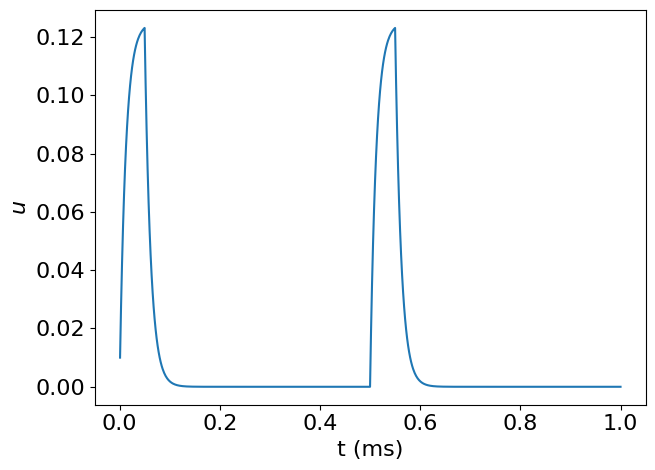

In [268]:
plt.plot(t_values,V_values)
plt.tick_params(labelsize=fontsize)
plt.xlabel(r't (ms)', fontsize=fontsize)
plt.tight_layout()
# plt.xlim([-10,500])
plt.ylabel(r'$u$', fontsize=fontsize)
plt.show()

In [269]:
txt[2,90]

IndexError: index 2 is out of bounds for axis 0 with size 1

In [270]:
beep(3)

-n 
-n 
-n 


0

In [271]:
# # #initialize system using resting state
# V   = -84.660321188012958
# f = 1.4545256072491180E-007
# s   =  5.5810241673725797E-003

In [309]:
# txt=load_txt
# val=np.array([0.95323689, 0.03156947, 0.83480313])
# val=np.array([0.94086643, 0.02150845, 0.82960188])
# val=np.array([0.92042215, 0.01465382, 0.82443303])
# val=np.array([0.1, 0.0, 0.9])
# val=np.array([0.09231135, 0.04974196, 0.90246904])
# val=np.array([0.09231135, 0.9, 0.90246904])
# val=np.array([0.08521385, 0.9049742 , 0.90487712])
# val=np.array([0.0, 0.9049742 , 0.90487712])
# val=np.array([1.24313601e-09, 9.05050190e-01, 9.07225741e-01])
# val=np.array([2.39387343e-09, 9.05126120e-01, 9.09516374e-01])
# val=np.array([1-2.39387343e-09, 9.05126120e-01, 9.09516374e-01])
# val=np.array([1-2.39387343e-09, 0.4, 0.89])
# val=np.array((1.0025495544029845, 0.4641893846980162, 0.9875777997223462))
# val=np.array((1.7844564762618417e-08, 0.9998230887712998, 0.9999999999999978))
# val=np.array((1.806315624723691e-08, 0.5778761361640079, 0.999370707631848))
val=np.array((1.806315624723691e-08, 0.0778761361640079, 0.999370707631848))

# val=np.array([2.39387343e-09, 0.9, 0.])
# val=np.array([2.39387343e-09, 0., 0.9])
# val=np.array([2.39387343e-09, 0., 0.])

# width=200
# height=200
width=1
height=1
txt=np.zeros(shape=(width,height,3))+val
# tf=1.00 #s
tf=.5 #s
dt=0.001 #s
# num_steps=int(tf/dt)
# dtxtdt=np.zeros_like(txt)
# for step in range(num_steps):
#     get_time_step_fk(txt, dtxtdt)
#     txt+=dtxtdt*dt
#     if t in range, add some external impulse to txt 
vlt,fig,sig = txt[0,0]
# dur=5e-3
# mag=-10
# dur=5e-2
# mag=-30.

dur=5e-2
mag=-40.
V_lst = [];
t_values=np.arange(dt,tf+dt,dt) #to match wj's implementation
dtxtdt=np.zeros_like(txt)
for t in t_values:
    dVlt2dt,dFig2dt,dSig2dt = comp_ionic_transient_fk(vlt,fig,sig)
    vlt+=dt*dVlt2dt*1e3
    fig+=dt*dFig2dt*1e3
    sig+=dt*dSig2dt*1e3
#     get_time_step_fk(txt, dtxtdt)
#     txt+=dtxtdt*dt
    #if t in range, add some external impulse to txt
    #compute external stimulus
    #if ((t>0.) & (t<=0.+dur))|((t>0.5) & (t<=0.5+dur))|((t>1.) & (t<=1.+dur)):
    if ((t>0.) & (t<0.+dur)):#ONE_SPIKE
        Istim=mag
    else:
        Istim=0.
#     txt+=np.array([-Istim*dt/Cm,0.,0.])
#     V_lst.append(txt[0,0,0])
    vlt+=-Istim*dt/Cm
    V_lst.append(vlt)

V_values=np.array(V_lst)

In [310]:
vlt,fig,sig

(1.9507498668419017e-07, 0.5499654299470839, 0.9940205063914155)

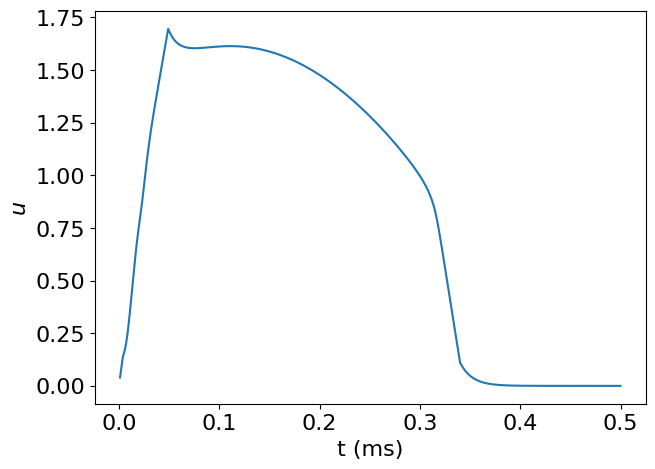

In [311]:
plt.plot(t_values,V_values)
plt.tick_params(labelsize=fontsize)
plt.xlabel(r't (ms)', fontsize=fontsize)
plt.tight_layout()
# plt.xlim([-10,500])
plt.ylabel(r'$u$', fontsize=fontsize)
plt.show()

In [312]:
# V=txt[...,0]
# dVdt=dtxtdt[...,0]

In [313]:
# dtxtdt.shape

# TODO: estimate AP Width

In [318]:
# DONE: estimate action potential duration versus threshold

#input: t_values,V_values
#output: thresh_values,AP_values
thresh_values=np.linspace(np.min(V_values)+0.01,
                          np.max(V_values)-0.01,
                          1000)

dt_ = np.diff(t_values)[0]
AP_lst=[]
for thresh in thresh_values:
    boo=V_values>=thresh
#     AP=np.diff(boo).sum()*dt_  #<<< assumes bi-monotonic action potential
    AP=boo.sum()*dt_  #<<< assumes bi-monotonic action potential
    #record
    AP_lst.append(AP)
AP_values=np.array(AP_lst); del AP_lst

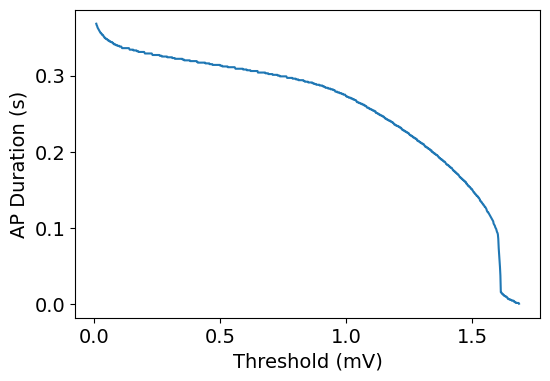

In [330]:
fig,ax=plt.subplots(figsize=(6,4))
ax.plot(thresh_values,AP_values)
format_plot(ax=ax,xlabel='Threshold (mV)',ylabel='AP Duration (s)',fontsize=14)
plt.show()

In [331]:
#TODO: convert yaxis to cm using conduction_velocity
#TODO: highlight/mark -40mV to indicate the value put in the table
#TODO: repeat ^this plot for FK model
#TODO: put both values in Table 1
#TODO: mention new values in Table 1 in the response to Referees
#TODO: update Table 2.1 in Dissertation with ^that value
conduction_velocity=51 #cm/s #FK
# conduction_velocity=33 #cm/s #LR
DX=0.025

# np.isclose(thresh_values,-40.,atol=).any()
hwindow=0.02 #mV
thresh=0.4
boo=(thresh_values-hwindow<=thresh)&(thresh_values+hwindow>=thresh)
boo.any(),boo.shape,V_values.shape

(True, (1000,), (500,))

In [332]:
ymean

0.31854166666666667

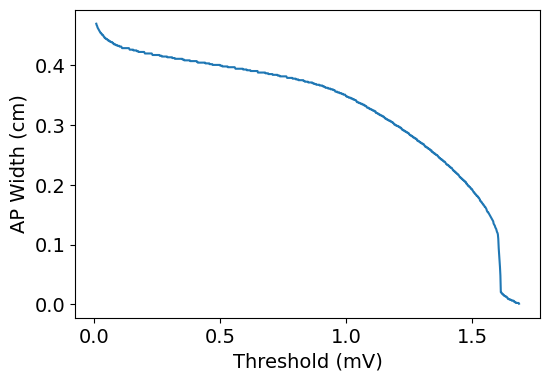

at thresh=0.4 mV, we have AP Duration: 0.3185 ms
at thresh=0.4 mV, we have AP Width: 0.4061 cm


In [334]:
ymean=np.mean(AP_values[boo])

fig,ax=plt.subplots(figsize=(6,4))
# ax.plot(thresh_values,AP_values*conduction_velocity*1e-3*DX)
ax.plot(thresh_values,AP_values*conduction_velocity*DX)


format_plot(ax=ax,xlabel='Threshold (mV)',ylabel='AP Width (cm)',fontsize=14)
plt.show()

print(f"at {thresh=} mV, we have AP Duration: {ymean:.4f} ms")
# print(f"at {thresh=} mV, we have AP Width: {ymean*conduction_velocity*1e-3*DX:.4f} cm")
print(f"at {thresh=} mV, we have AP Width: {ymean*conduction_velocity*DX:.4f} cm")

For reference scale, the width of a planar wave was 0.406 cm for the FK model and 0.149 cm for the LR model.  These widths were computed at the same thresholds used for the detection of spiral tip locations (See Methods) as the product of action potential duration and conduction velocity.